# Generative Learning II

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_I_ML_Dynamical_Systems/Lecture%2011/Lecture_9.ipynb)


# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





# 1. Problem Definition: Probe into the Data

This time, we will use several work of [Franz Schubert](https://en.wikipedia.org/wiki/Franz_Schubert). He was an Austrian composer of the late Classical and early Romantic eras. Despite his short lifetime, he left behind created more than 600 secular vocal works, seven complete symphonies, operas, incidental music and a large body of piano and chamber music. 

Today, we will use parts of his legacy to become composers ourselves by the means of generative learning. The MIDI files were taken from [piano-midi.de](http://www.piano-midi.de/schub.htm). 


# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
# Loading libraries:
#
#Fundamentals
import numpy as np
import pandas as pd
import os
#
# Aux. libs:
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
import glob
import imageio
from PIL import Image
import time
import IPython.display as ipd
from music21 import converter, instrument, note, stream, chord, duration
#import midi2img
import librosa
import img2midi
#
#ML libraries
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers, utils
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
from tensorflow.keras.regularizers import l1_l2

AUTOTUNE = tf.data.experimental.AUTOTUNE

**Note that** you need to install the recent version of music 21 if you want to use midi2img python script to convert MIDI files to images.

In [2]:
!#pip install music21==7.1.0


In [3]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.0 MB/s eta 0:00:00
time: 395 µs (started: 2023-02-02 12:01:23 +00:00)


In [4]:
#For MIDI conversion:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
#Calling libs:
from midi2audio import FluidSynth
from IPython.display import Audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 27 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe a

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

time: 761 ms (started: 2023-02-02 12:01:59 +00:00)


# 3. Pre-processing


## Loading the Data

In [6]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

time: 16.9 s (started: 2023-02-02 12:01:59 +00:00)


In [7]:
downloaded = drive.CreateFile({'id':'1EShMBFF7y6GczF1ZJMDdd7zD9zEeQKS7'}) 
downloaded.GetContentFile('Images.zip')
os.chdir("/content")
!unzip -q /content/Images.zip 
!ls

font.sf2  Images.zip   midi2img.py  sample_data
Images	  img2midi.py  __pycache__
time: 4.01 s (started: 2023-02-02 12:02:16 +00:00)


## Converting Music into our Input Matrix

A **note** can be understood as a symbolic representation of a sound, which is described by its **pitch** (in combination with the clef) and **duration**. A note's pitch is related to the frequency of oscillation of its sound wave, measured in hertz (Hz). For instance, notes with higher pitches have sound waves with more oscillations per second. A note's duration, on the other hand, is the length of the period over which it is played.

A **chord** is a combination of multiple (at least two, but mostly three) notes with different intervals played simultaneously on the same instrument. For a single instrument, we can identify chords by assuming that all notes played at the exact same time are part of the same chord. This simplifying assumption is not valid if we have polyphonic music, that is, if we have two or more instruments playing simultaneously.

**How are we going to use notes?**

Musical data is needed to be processed before feeding it into any ML algorithm. The conversion is naturally linked to the original form of the dataset. You can, for example, 'listen' to mp3 files and learn to compose by just 'listening'. An alternative is to use the mathematics of music and notes, which we relied on last week. 

This time, we will convert the musical information first into a **images**. Then, we will take this **encoded sparse data** and feed it to a NN that works well with images. For that purpose, we will use a combination of MLPs and CNNs (we will learn about them in the second lecture).

Once trained, our model will learn to **predict the right amount of pitch and duration** simultaneously via encoded images.


For data processing, we are relying on `music21` library to load the MIDI files into Python enviroment. For MIDI, see: 

https://en.wikipedia.org/wiki/MIDI


Furthermore, we will use 2 **external python scripts** to convert MIDI files to images in a reversible way. If you are working in Colab, you need to **upload these files** to the cloud machine.

### Reading our data:

In [8]:
# Defining the directory:
#save_dir = '/content/haydn/'

# Identify list of MIDI files
#songList = os.listdir(save_dir)

time: 436 µs (started: 2023-02-02 12:02:20 +00:00)


### Creating images:

For the lecture, I have created the images locally and prepared a zip file including all the images. If you want to upload MIDI files and do the image conversion on Colab, you need to upgrade the music21 library (above) and uncomment the below cells.

Since image conversion is not our primary concern here, I did it externally to avoid music21 upgrade everytime we open the notebook.

In [9]:
# Create empty list:
# Here we are creating a list of directories to loop over later on:
#---------------------------------------------------------------------
#originalSongs = []
# Step 1: Load and make list of stream objects
#for song in songList:
#    originalSongs.append(save_dir+song)

time: 544 µs (started: 2023-02-02 12:02:20 +00:00)


In [10]:
#Creating an Image folder:
#-------------------------
#!mkdir /content/Images
#!ls "/content/Images"

time: 493 µs (started: 2023-02-02 12:02:20 +00:00)


In [11]:
#importing the function for midi to image conversion:
#-----------------------------------------------------
#from midi2img import midi2image

time: 296 µs (started: 2023-02-02 12:02:20 +00:00)


In [12]:
#Conversion process:
#----------------------
#new_dir = '/content/Images'
#os.chdir(new_dir)
#for i, song in enumerate(originalSongs):
  #print(song)
#  midi2image(song)
#os.chdir("/content")

time: 561 µs (started: 2023-02-02 12:02:20 +00:00)


In [13]:
img_dir = '/content/Images/'
imgList = os.listdir(img_dir)
imageDir = []
for image in imgList:
    imageDir.append(img_dir+image)

time: 1.95 ms (started: 2023-02-02 12:02:20 +00:00)


In [14]:
# Image processing
# using Image library for improving image quality. In our case, this was not necessary so
# it is commented out.
#-----------------------------------------------------------------------------------------
#basewidth = 144
#hsize = 144
#for imagePath in imageDir:
#  img = Image.open(imagePath)
#  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
#  img.save(imagePath)

time: 322 µs (started: 2023-02-02 12:02:20 +00:00)


## Converting Images into pixels

At this point, our training dataset is ready. You should either use the pre-coverted images, or take a MIDI zip file that you want to work on and convert the MIDIs to images by yourself via `midi2img` script.

The next step is to convert images to an array of pixels so that our ML model can work with them. For that purpose, we will create a function `image_to_px`, which takes the image directory list as an input and create a list of arrays. 

Here, we also scale the px data in a symmetric way, so that they will range between [-1,1].

In [15]:
def image_to_px(image_dir_list):
  px = []
  for image_dir in image_dir_list:
    img = Image.open(image_dir,'r')
    pixels = np.array(img.getdata())
    pixels = pixels.astype('float32')
    pixels = (pixels - 127.5) / 127.5    
    px.append(pixels.reshape(144,144,1))
  return np.array(px)

time: 1.29 ms (started: 2023-02-02 12:02:20 +00:00)


In [16]:
def show_image(px_list):
  """
  This function takes a pixel matrix, reshape it, convert data type to int. ranged between [0,255].
  Next, creates an image object and show it.
  """
  array = np.array(px_list.reshape(144,144), dtype=np.uint8)
  new_image = Image.fromarray(array)
  new_image.show()

time: 1.55 ms (started: 2023-02-02 12:02:20 +00:00)


In [17]:
# Calling the image converter function:
px_data = image_to_px(imageDir)
# Checking the unique values. As expected, we see only -1 and 1. 
np.unique(px_data)

array([-1.,  1.], dtype=float32)

time: 1.72 s (started: 2023-02-02 12:02:20 +00:00)


# Simple GAN

## Preliminaries

In the GAN training, we need to feed the model with mini-batches of real and fake images. In order make the loop simpler, we will first define 3 functions:

1. Select n number of real images randomly from the image dataset. We will call this function as `generate_real_samples`. Note that here we also return the labels as "-1". This will be used in approximate Wasserstein loss function.

2. A function to create the Gaussian noise input to the generator model. It will read the number of latent dimension (a hyperparameter to play with) and number of samples. We call it as `generate_latent_points`.

3. A function that calls the generator function for a given number of latent dimension and sample size. We call it `generate_fake_examples`. Note that here we also return the labels as +1. This will be used in approximate Wasserstein loss function.



In [18]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    #class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
def generate_fake_samples(generator_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator_model.predict(x_input)
    #class labels, 1 for 'fake'
    y = ones((n_samples, 1))
    return X, y

time: 1.13 ms (started: 2023-02-02 12:02:22 +00:00)


In the vanilla GAN, binary cross entropy was used as a loss function. In WGAN, we will define our custom loss function by using assigned label values. The idea is to convert classification problem into a regression problem so that the Discriminator will give us scores for real and fake examples. Here, the objective is to make the distance between the real and fake samples as large as possible. We will use it as an approximation of Wasserstein distance. Note that this is not exactly W distance, it is a very simple interpretation inspired from it. 

To create such a cost function for a mini-batch of samples, we need to calculate the mean of discrete samples. This is done by using the mean method from keras backend. 

Wasserstein loss calculation here might look confusing at a first glance. Lets see over an example. Say that Discriminator give a score of 10 for both a real and fake example. The loss for real case becomes -10 and the fake case become 10. So, they are separated much more than a case of (5,5). Here the signs are arbitrary. The point is real and fake should be in opposite locations if the Discriminator model gave the same output for both. 

In [19]:
from keras import backend
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

time: 576 µs (started: 2023-02-02 12:02:22 +00:00)


Another issue with Wasserstein GAN is to enforce a [Lipschitz constrain](https://en.wikipedia.org/wiki/Lipschitz_continuity). 

[Authors of WGAN](https://arxiv.org/pdf/1701.07875.pdf) describe it as follows:

*Weight clipping is a clearly terrible way to enforce a Lipschitz constraint. If the clipping parameter is large, then it can take a long time for any weights to reach their limit, thereby making it harder to train the critic till optimality. If the clipping
is small, this can easily lead to vanishing gradients when the number of layers is big, or batch normalization is not used (such as in RNNs). We experimented with simple variants (such as projecting the weights to a sphere) with little difference, and we stuck with weight clipping due to its simplicity and already good performance.
However, we do leave the topic of enforcing Lipschitz constraints in a neural network setting for further investigation, and we actively encourage interested researchers to improve on this method.*

For an explicit description, you can see the video from the [DeepMind](https://youtu.be/wFsI2WqUfdA?t=756).

For TF implementation, we will create a class and use it:

In [20]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

time: 1.06 ms (started: 2023-02-02 12:02:22 +00:00)


## Building GAN

### Discriminator

Model architecture is arbitrary and custom-made. Depending on the data type, you need to use a good combination of NN layers. Our input is an image, so we will use a special layer for image processing called convolutional layer. This enables to process high dimensional data (144x144) with minimum number of weights. You will learn more about them in the second lecture.

We basically have 2 image processing layers and one Dense layer with 1 neuron. The activation function is linear, so that it acts like a score generator. 

One rule of thumb here is to keep discriminator simpler that the generator, as discriminator usually beats the generator.

*Note: In my experience, sometimes kernel_regularizer works even better than the weight clipping when creating discriminators. If the performance is not acceptable, you can try it.*

In [21]:
def define_discriminator(in_shape = (144,144,1)):
    const = ClipConstraint(0.01)
    #kernel_regularizer = l1_l2(l1=0.01, l2=0.01)
    model = Sequential()
    model.add(Conv2D(64, (4,4),strides=(2,2),padding='same',kernel_initializer="he_normal", kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (4,4),strides=(2,2),kernel_initializer="he_normal",kernel_constraint=const, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    # compile model
    opt = RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

time: 1.38 ms (started: 2023-02-02 12:02:22 +00:00)


In [22]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 72, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 72, 72, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 72, 72, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        65600     
                                                                 
 batch_normalization_1 (Batc  (None, 36, 36, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 36, 64)        0

### Generator

The generator will take the noise matrix as an input and connect it to a big dense layer. This information is then passed reshaped into an image format with 128 channels (parallel matrices). We then gradually increase the size of the matrices and collapse all the channels into one at the final layer. 

In [23]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 72 * 72
    model.add(Dense(n_nodes,kernel_initializer="he_normal", input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((72, 72, 128)))
    model.add(Dense(1024))
    model.add(Conv2DTranspose(1024, (4,4), strides=(2,2),kernel_initializer="he_normal",padding='same')) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'tanh'))
    return model

time: 2.2 ms (started: 2023-02-02 12:02:25 +00:00)


In [24]:
latent_dim = 72
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 663552)            48439296  
                                                                 
 batch_normalization_2 (Batc  (None, 663552)           2654208   
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 663552)            0         
                                                                 
 reshape (Reshape)           (None, 72, 72, 128)       0         
                                                                 
 dense_2 (Dense)             (None, 72, 72, 1024)      132096    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 144, 144, 1024)   16778240  
 nspose)                                              

### GAN

Here we will combine D and G to create the GAN model. Note that here the discriminator model is not trainable. Only the weight of the generator will be updated.

In [25]:
def define_gan(g_model, d_model):
    for layer in d_model.layers:
      if not isinstance(layer, BatchNormalization):
        layer.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

time: 1.33 ms (started: 2023-02-02 12:02:25 +00:00)


In [26]:
GAN_model = define_gan(generator,discriminator)

time: 261 ms (started: 2023-02-02 12:02:25 +00:00)


### Loading pretrained generator

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 16.5 s (started: 2023-02-02 12:02:26 +00:00)


In [28]:
generator = tf.keras.models.load_model('/content/drive/MyDrive/DDE_1/GANs/model_1092.h5')

time: 6.8 s (started: 2023-02-02 12:02:42 +00:00)


In [29]:
GAN_model = define_gan(generator,discriminator)

time: 83.4 ms (started: 2023-02-02 12:02:49 +00:00)


# Training GAN

Since GAN training is tricky, we will save the intermediate models with some plotted examples to babysit the learning process. 

The below function reads the training step number, and create n number of samples (4) to illustrate how the generator works. The result will be saved on the cloud, as well as the generator model. Here the name of the model will be based on the training step.

In [30]:
def summarize_performance(step, g_model, latent_dim, n_samples=4):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(2 * 2):
		# define subplot
		pyplot.subplot(2, 2, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = '/content/generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

time: 1.39 ms (started: 2023-02-02 12:02:49 +00:00)


After the training is done, we can see the relative scores for the discriminator and the generator. The figure will also be saved on the cloud machine.

In [31]:
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='d_real')
	pyplot.plot(d2_hist, label='d_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('/content/plot_line_plot_loss.png')
	#pyplot.close()

time: 589 µs (started: 2023-02-02 12:02:49 +00:00)


### Training starts here ...

As usual, we need to decide number of epochs and number of examples in a batch. This time, however, we need to micro-manage the training process in GAN.

The algorithm discussed in the lecture notes includes two training steps: one for the Discriminator and one for the Generator. For the discriminator, we will create a mixture of samples from real and fake examples and update the weights of the D model. This is done by `train_on_batch` method.

For the generator, we will also use the same method for `n_batch` of examples.

In [32]:
#Hyperparameters:
#-----------------
n_epochs=10
n_batch=16
image_dataset = np.array(px_data)
batch_per_epo = int(image_dataset.shape[0] / n_batch)
half_batch = int(n_batch / 2)
n_steps = batch_per_epo * n_epochs
n_discriminator = 5

time: 12 ms (started: 2023-02-02 12:02:49 +00:00)


In [33]:
# lists for keeping track of loss
d1_hist, d2_hist, g_hist = list(), list(), list()
#-----------------------------------------------
# training loop:
for i in range(n_steps):
  # Inner loop for the discriminator: we fist create empty temp. lists.
  d1_tmp, d2_tmp = list(), list()
  for _ in range(n_discriminator):
    # creating randomly selected 'real' samples:
    X_real, y_real = generate_real_samples(image_dataset, half_batch)
    # update Discriminator model weights:
    d_loss1 = discriminator.train_on_batch(X_real, y_real)
    d1_tmp.append(d_loss1)
    # generating 'fake' examples:
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
    # update Discriminator model weights:
    d_loss2 = discriminator.train_on_batch(X_fake, y_fake)
    d2_tmp.append(d_loss2)
  # storing mean current Discriminator losses:
  d1_hist.append(mean(d1_tmp))
  d2_hist.append(mean(d2_tmp))
  # creating input for the generator:
  X_gan = generate_latent_points(latent_dim, n_batch)
  # create inverted labels for the fake samples. 
  # We are trying to trick the discriminator here!
  y_gan = -ones((n_batch, 1))
  # update the generator via the discriminator error:
  g_loss = GAN_model.train_on_batch(X_gan, y_gan)
  g_hist.append(g_loss)
  # print the loss for the training batch:
  # Note that we are presenting the real and fake losses separately for the discriminator.
  print('Step:%d, D on real=%.3f, D on fake=%.3f G=%.3f' % (i+1, d1_hist[-1], d2_hist[-1], g_loss))
  # summary of the model performance for  every m 'epoch'. Here m is 1.
  if (i+1) % (1* batch_per_epo) == 0:
    summarize_performance(i, generator, latent_dim)

1/1 [==============================] - 0s 418ms/step
Step:1, D on real=-1.044, D on fake=2.151 G=-0.297
1/1 [==============================] - 0s 425ms/step
Step:2, D on real=-1.964, D on fake=1.176 G=-0.680
1/1 [==============================] - 0s 428ms/step
Step:3, D on real=-2.023, D on fake=1.411 G=0.013
1/1 [==============================] - 0s 446ms/step
Step:4, D on real=-2.530, D on fake=1.227 G=0.506
1/1 [==============================] - 0s 451ms/step
Step:5, D on real=-3.261, D on fake=1.806 G=-0.123
1/1 [==============================] - 0s 441ms/step
Step:6, D on real=-4.061, D on fake=2.376 G=-0.587
1/1 [==============================] - 0s 441ms/step
Step:7, D on real=-4.687, D on fake=1.874 G=-1.552
1/1 [==============================] - 0s 440ms/step
Step:8, D on real=-4.799, D on fake=2.153 G=-0.947
1/1 [==============================] - 0s 442ms/step
Step:9, D on real=-5.056, D on fake=2.044 G=-1.197
1/1 [==============================] - 0s 430ms/step
Step:10, D on

KeyboardInterrupt: ignored

time: 2min 1s (started: 2023-02-02 12:02:49 +00:00)


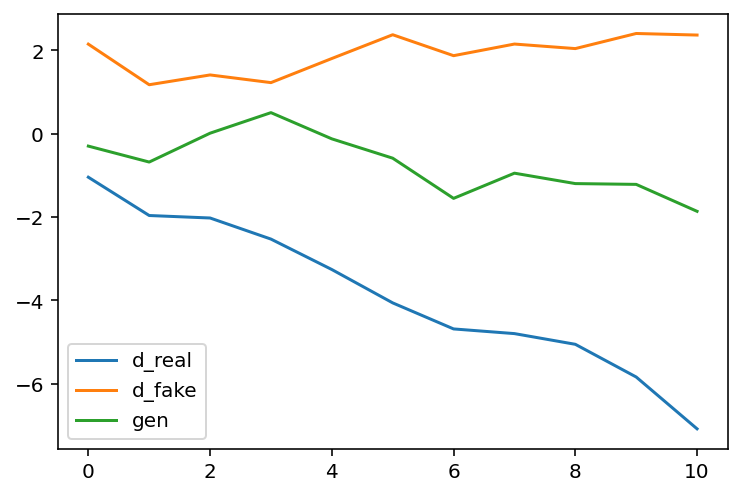

time: 241 ms (started: 2023-02-02 12:04:59 +00:00)


In [34]:
# line plots of loss
plot_history(d1_hist, d2_hist, g_hist)

### Storing the results on drive

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.64 s (started: 2023-02-02 12:04:59 +00:00)


In [36]:
!cd /content
!mkdir GANS_data_2

time: 324 ms (started: 2023-02-02 12:05:02 +00:00)


In [37]:
!mv /content/*.h5 /content/GANS_data_2/

mv: cannot stat '/content/*.h5': No such file or directory
time: 161 ms (started: 2023-02-02 12:05:02 +00:00)


In [38]:
!cp -r /content/GANS_data_2 /content/drive/MyDrive/DDE_1/GANs/

time: 157 ms (started: 2023-02-02 12:05:02 +00:00)


### Music generation

In [39]:
# generate images
latent_points = generate_latent_points(latent_dim,1)
# generate images
X = generator.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

1/1 [==============================] - 1s 919ms/step
time: 958 ms (started: 2023-02-02 12:05:02 +00:00)


In [40]:
array = np.array(X.reshape(144,144))
array = np.where(array<0.1,0,1)
array*= 255
array = array.astype(np.uint8)

time: 1.7 ms (started: 2023-02-02 12:05:03 +00:00)


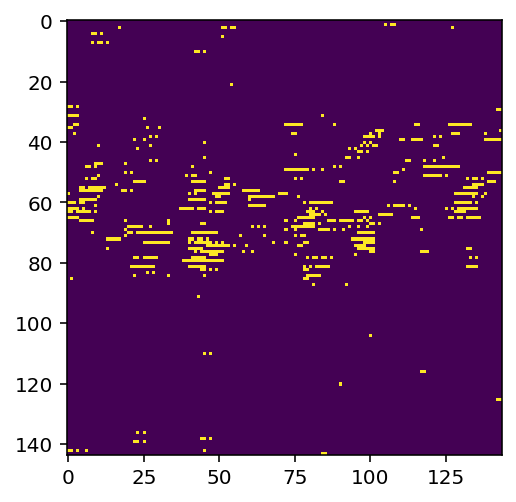

time: 186 ms (started: 2023-02-02 12:05:03 +00:00)


In [41]:
plt.imshow(array)

In [42]:
new_image = Image.fromarray(array,'L')
new_image = new_image.save('composed.png')

time: 1.89 ms (started: 2023-02-02 12:05:04 +00:00)


In [43]:
import img2midi

time: 364 µs (started: 2023-02-02 12:05:04 +00:00)


In [44]:
img2midi.image2midi('composed.png')

<music21.stream.Stream 0x7fadfa13ff70>

time: 161 ms (started: 2023-02-02 12:05:04 +00:00)


In [45]:
#File conversion:
FluidSynth("font.sf2").midi_to_audio('composed.mid', 'GAN.wav')
Audio("GAN.wav")

time: 766 ms (started: 2023-02-02 12:05:04 +00:00)


# References

Fun data libraries for music:

http://www.jsbach.net/midi/midi_solo_cello.html

https://www.mutopiaproject.org/

http://www.piano-midi.de/

http://millionsongdataset.com/

https://github.com/mdeff/fma

Some notebooks and pre-trained models for music generation:

https://fephsun.github.io/2015/09/01/neural-music.html

https://arxiv.org/pdf/1612.01010.pdf




